In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_matches = pd.read_csv('../../data/preprocessed/preprocessed_1.csv')
df_matches.sort_values(by=["season", "stage", "date"], inplace=True)

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score


def train_and_evaluate(train_df, val_df, test_df):
    feature_cols = [col for col in train_df.columns if col not in
                    ["match_api_id", "result_match", "season", "stage", "date", "home_team", "away_team"]]

    X_train = train_df[feature_cols]
    y_train = train_df["result_match"]

    X_val = val_df[feature_cols]
    y_val = val_df["result_match"]

    X_test = test_df[feature_cols]
    y_test = test_df["result_match"]

    model = XGBClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
    )

    # Fit on training and validate on validation set
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=False)
    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

In [22]:
# ---------------------
# Backtesting over multiple seasons
# ---------------------

seasons = sorted(df_matches["season"].unique())
backtest_results = []

for target_season in seasons[1:]:
    previous_seasons = [s for s in seasons if s < target_season]

    target_season_df = df_matches[df_matches["season"] == target_season]

    target_stages = sorted(target_season_df["stage"].unique())

    for stage in target_stages:
        if stage <= min(target_stages) + 1:
            continue

        train_df_prev = df_matches[df_matches["season"].isin(previous_seasons)]
        train_df_target = target_season_df[target_season_df["stage"] < (stage - 1)]
        train_df = pd.concat([train_df_prev, train_df_target], ignore_index=True)

        val_df = target_season_df[target_season_df["stage"] == (stage - 1)]
        test_df = target_season_df[target_season_df["stage"] == stage]

        if train_df.empty or val_df.empty or test_df.empty:
            continue

        f1 = train_and_evaluate(train_df, val_df, test_df)
        backtest_results.append({
            "season": target_season,
            "stage": stage,
            "train_size": len(train_df),
            "f1_score": f1
        })

results_df = pd.DataFrame(backtest_results)
print("Backtesting results for each season and stage:")
results_df

Backtesting results for each season and stage:


,season,stage,train_size,f1_score
0,2009/2010,3,362,0.333333
1,2009/2010,4,369,0.400000
2,2009/2010,5,379,0.727273
3,2009/2010,6,389,0.250000
4,2009/2010,7,399,0.727273
...,...,...,...,...
247,2015/2016,34,2915,0.333333
248,2015/2016,35,2925,0.666667
249,2015/2016,36,2935,0.444444
250,2015/2016,37,2945,0.400000


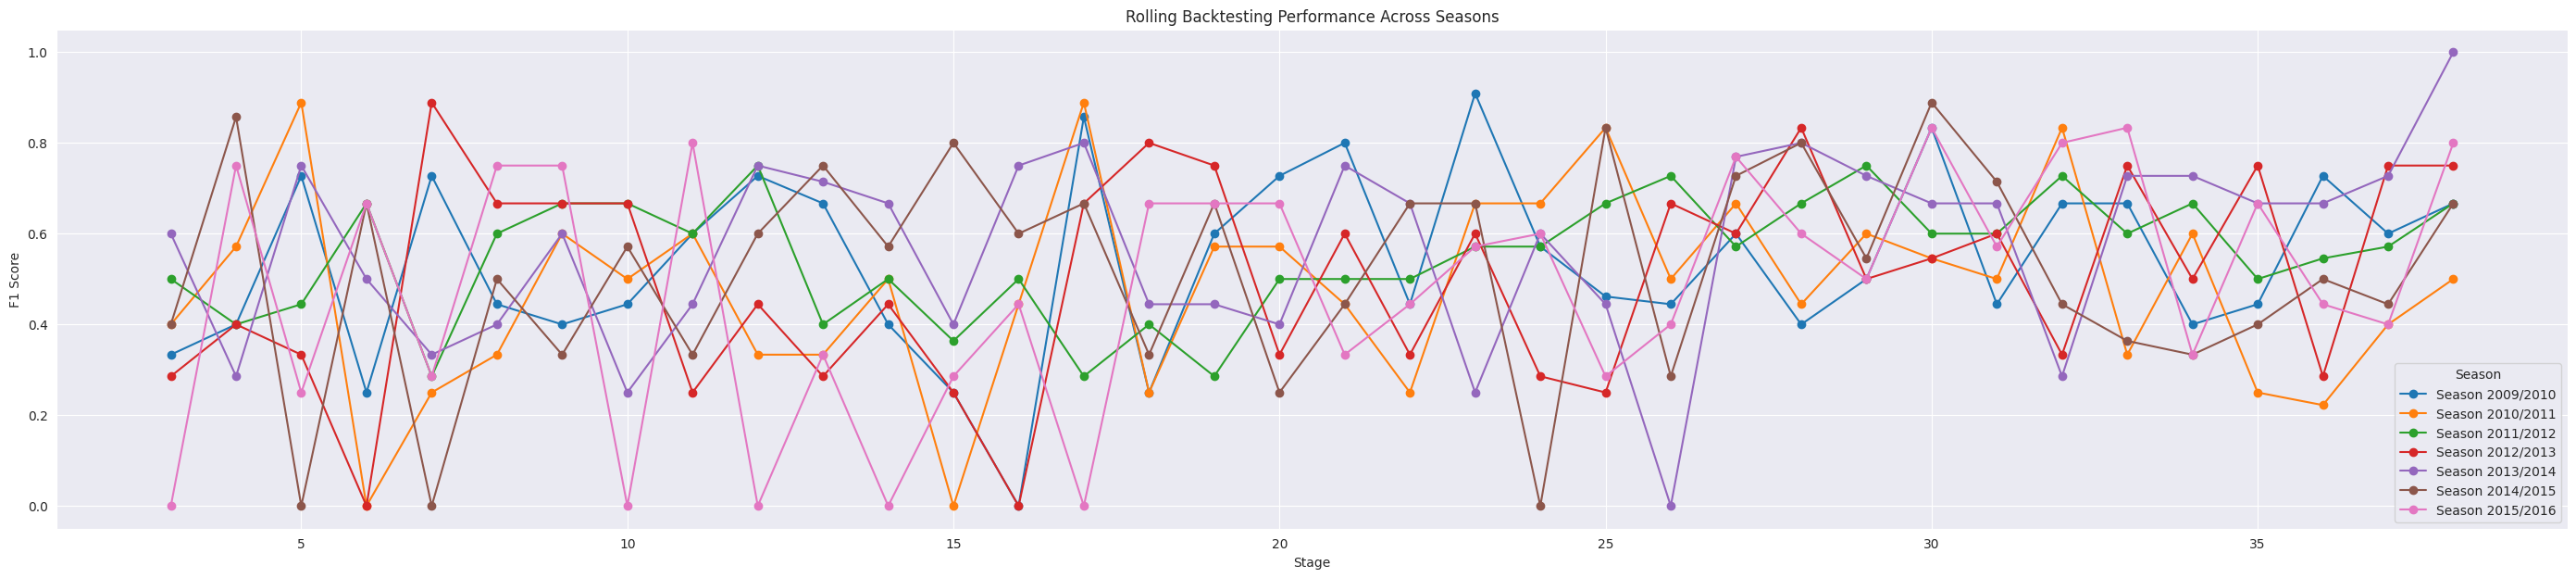

In [23]:
plt.figure(figsize=(35, 7))
for season in results_df["season"].unique():
    season_results = results_df[results_df["season"] == season]
    plt.plot(season_results["stage"], season_results["f1_score"], marker="o", label=f"Season {season}")

plt.xlabel("Stage")
plt.ylabel("F1 Score")
plt.title("Rolling Backtesting Performance Across Seasons")
plt.legend(title="Season")
plt.grid(True)
plt.show()


Average F1 Score for each season:
      season  avg_f1_score
0  2009/2010      0.538488
1  2010/2011      0.480363
2  2011/2012      0.550489
3  2012/2013      0.501836
4  2013/2014      0.574310
5  2014/2015      0.517368
6  2015/2016      0.486182


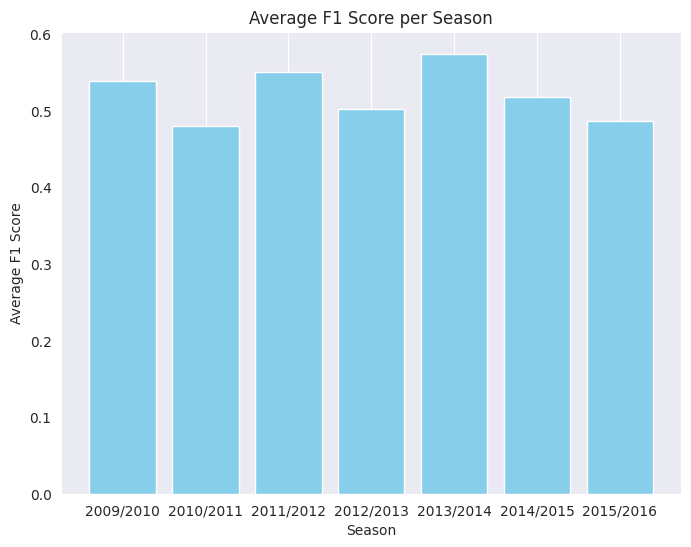

In [24]:
avg_results = results_df.groupby("season")["f1_score"].mean().reset_index()
avg_results.rename(columns={"f1_score": "avg_f1_score"}, inplace=True)
print("\nAverage F1 Score for each season:")
print(avg_results)

plt.figure(figsize=(8, 6))
plt.bar(avg_results["season"].astype(str), avg_results["avg_f1_score"], color='skyblue')
plt.xlabel("Season")
plt.ylabel("Average F1 Score")
plt.title("Average F1 Score per Season")
plt.grid(axis='y')
plt.show()

In [7]:
from src.helper import get_split_data

X_trn, y_trn, X_val, y_val, X_tst, y_tst = get_split_data.split_data_for_training(4)

In [8]:
X_trn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1848 entries, 0 to 1847
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   points_home                1848 non-null   int64  
 1   points_away                1848 non-null   int64  
 2   home_last_team_goal        1848 non-null   float64
 3   home_last_team_shoton      1848 non-null   float64
 4   home_last_team_possession  1848 non-null   float64
 5   away_last_team_goal        1848 non-null   float64
 6   away_last_team_shoton      1848 non-null   float64
 7   away_last_team_possession  1848 non-null   float64
 8   team_strength_home         1848 non-null   float64
 9   team_strength_away         1848 non-null   float64
 10  strength_difference        1848 non-null   float64
 11  team_aggression_home       1848 non-null   float64
 12  team_aggression_away       1848 non-null   float64
 13  aggression_difference      1848 non-null   float

In [11]:
(X_trn
 .assign(result_match=y_trn)
 .corr(method='spearman')
 .style
 .background_gradient(cmap='RdBu', vmax=1, vmin=-1)
 .set_sticky(axis='index')
 )

,points_home,points_away,home_last_team_goal,home_last_team_shoton,home_last_team_possession,away_last_team_goal,away_last_team_shoton,away_last_team_possession,team_strength_home,team_strength_away,strength_difference,team_aggression_home,team_aggression_away,aggression_difference,team_acceleration_home,team_acceleration_away,acceleration_difference,points_difference,goal_conversion_rate_home,goal_conversion_rate_away,rolling_avg_goals_home,rolling_avg_goals_away,result_match
points_home,1.000000,0.775753,0.086957,0.055509,-0.094802,0.023081,0.000698,-0.002626,0.072861,0.039331,0.023411,0.095660,0.043878,0.046693,0.066654,-0.054472,0.079587,0.300089,0.016131,0.014569,0.172977,-0.021360,0.151642
points_away,0.775753,1.000000,-0.011981,-0.023465,-0.020367,0.135605,0.063328,-0.078669,0.045304,0.087897,-0.030285,0.023426,0.118072,-0.071466,-0.047018,0.061998,-0.086841,-0.328411,0.002462,0.057461,-0.016070,0.177678,-0.045403
home_last_team_goal,0.086957,-0.011981,1.000000,0.078706,-0.092328,-0.021983,0.036260,-0.028959,-0.028031,0.010355,-0.026942,-0.015613,0.027650,-0.021595,0.094075,0.019238,0.064540,0.140868,0.669943,-0.045530,0.537249,0.015063,0.064299
home_last_team_shoton,0.055509,-0.023465,0.078706,1.000000,-0.260403,-0.000645,-0.007583,0.001207,0.038556,0.015166,0.024630,0.017216,0.012210,0.002520,0.099568,-0.015887,0.096188,0.120857,-0.655376,0.011464,0.116768,0.021648,0.088651
home_last_team_possession,-0.094802,-0.020367,-0.092328,-0.260403,1.000000,0.045005,0.001907,-0.017214,0.000249,-0.013010,0.006317,-0.031361,-0.016132,-0.012848,-0.078544,0.001082,-0.066426,-0.112121,0.114709,0.035915,-0.125644,0.024980,-0.057656
away_last_team_goal,0.023081,0.135605,-0.021983,-0.000645,0.045005,1.000000,0.084554,-0.090198,0.015984,0.056934,-0.021341,-0.001185,0.055419,-0.046775,-0.017993,0.095991,-0.078964,-0.167884,-0.014494,0.685330,0.002469,0.562880,-0.053594
away_last_team_shoton,0.000698,0.063328,0.036260,-0.007583,0.001907,0.084554,1.000000,-0.196899,0.004445,0.030348,-0.021115,0.003030,0.005228,0.000974,0.007711,0.106114,-0.076053,-0.095361,0.034871,-0.637029,0.035644,0.108780,-0.074268
away_last_team_possession,-0.002626,-0.078669,-0.028959,0.001207,-0.017214,-0.090198,-0.196899,1.000000,-0.003179,-0.019054,0.010860,0.007987,-0.016623,0.021406,0.033693,-0.061699,0.064034,0.125164,-0.029264,0.076856,-0.028522,-0.130676,0.068172
team_strength_home,0.072861,0.045304,-0.028031,0.038556,0.000249,0.015984,0.004445,-0.003179,1.000000,0.045976,0.672980,0.662668,0.101506,0.401676,-0.238735,-0.039615,-0.151950,0.040552,-0.050677,0.008333,0.012735,0.029087,0.013606
team_strength_away,0.039331,0.087897,0.010355,0.015166,-0.013010,0.056934,0.030348,-0.019054,0.045976,1.000000,-0.667279,0.088030,0.668449,-0.444697,-0.073585,-0.211152,0.105803,-0.072814,-0.006321,0.023679,0.003678,0.046372,-0.048819


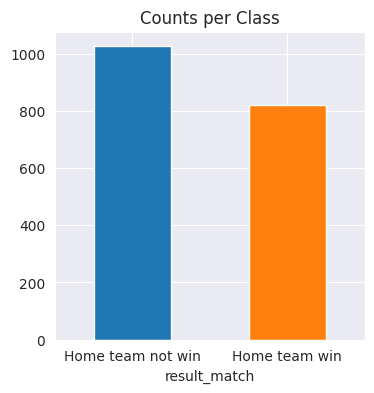

In [13]:
fig, ax = plt.subplots(figsize=(4, 4))
y_trn.value_counts().plot(
    kind='bar',
    ax=ax,
    color=['tab:blue', 'tab:orange']
)
ax.set_title('Counts per Class')
ax.set_xticklabels(['Home team not win', 'Home team win'], rotation=0)
plt.show()

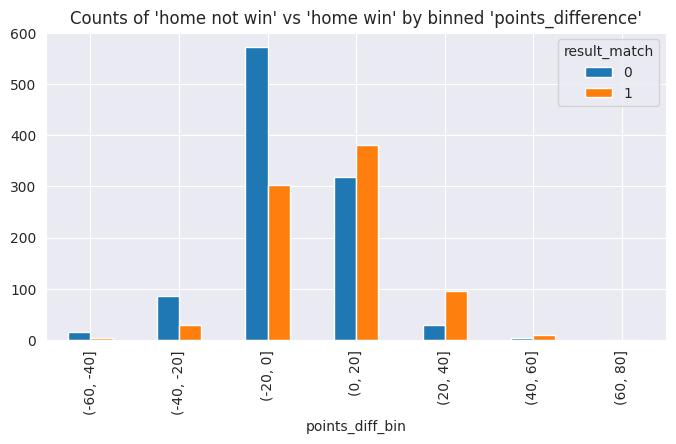

In [14]:
bins = pd.cut(
    X_trn['points_difference'],
    bins=[-60, -40, -20, 0, 20, 40, 60, 80],
)

X_train = X_trn.assign(result_match=y_trn)
X_train['points_diff_bin'] = bins

fig, ax = plt.subplots(figsize=(8, 4))
(
    X_train
    .groupby('points_diff_bin', observed=False)['result_match']
    .value_counts()
    .unstack()
    .plot.bar(ax=ax)
)
ax.set_title("Counts of 'home not win' vs 'home win' by binned 'points_difference'")
plt.show()

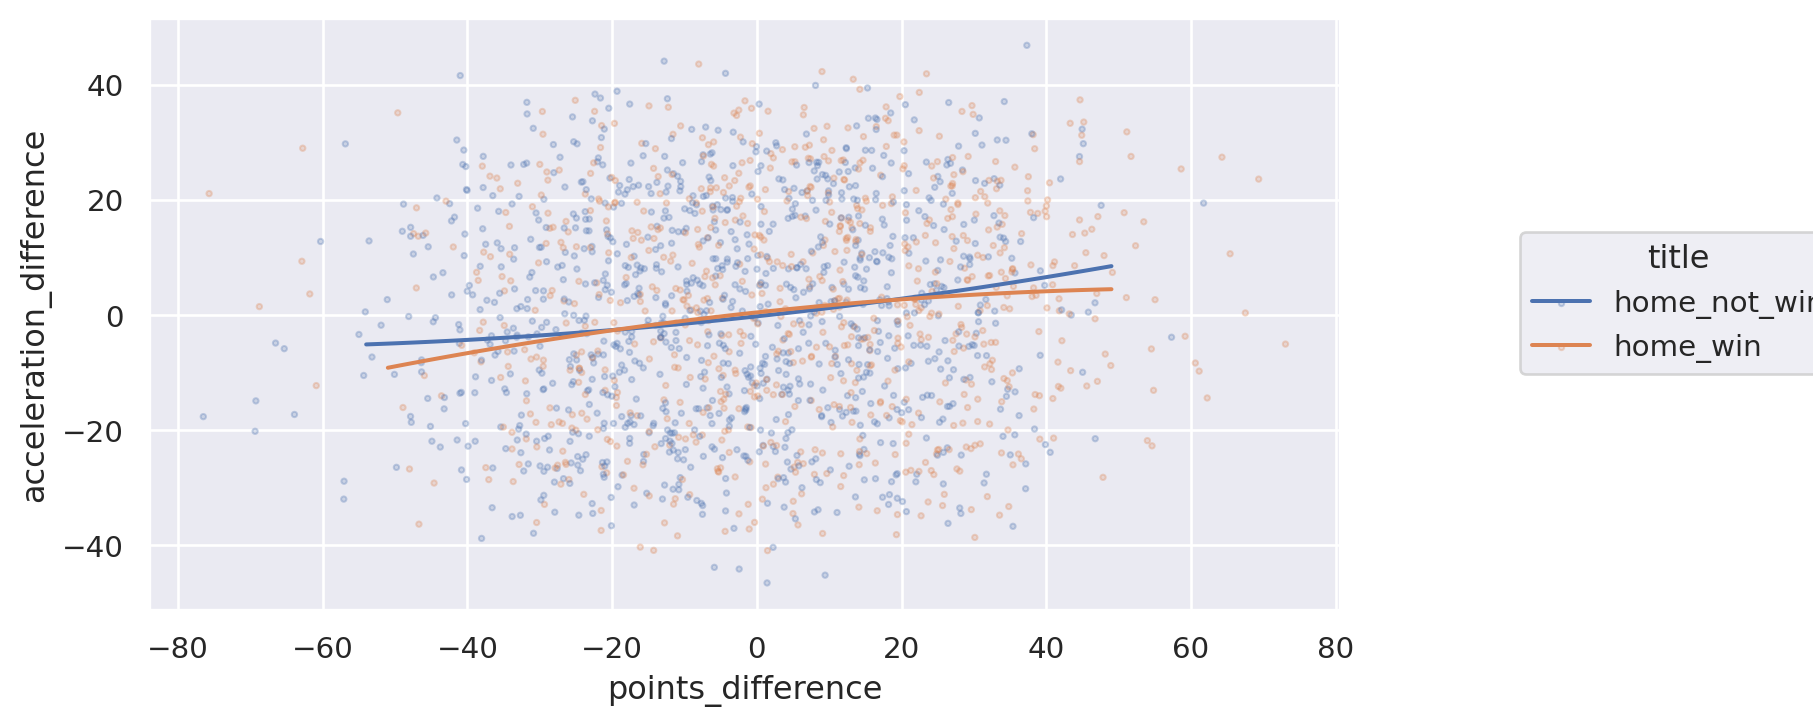

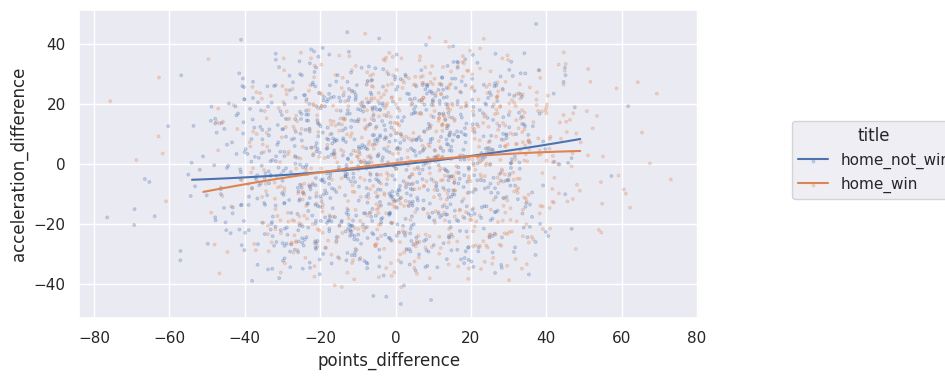

In [15]:
import seaborn.objects as so

fig = plt.figure(figsize=(8, 4))
(so
 .Plot(X_trn.assign(title=y_trn.apply(lambda x: 'home_win' if x == 1 else 'home_not_win')), x='points_difference', y='acceleration_difference', color='title')
 .add(so.Dots(alpha=.3, pointsize=2), so.Jitter(x=70, y=60))
 .add(so.Line(), so.PolyFit())
 .on(fig)
 .plot()
 )